In [1]:
import os
import os.path as p
import sys
import ee
import geemap
import seaborn as sns
from matplotlib import pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from util.helper import get_scene_id
root_ = '/Users/yuhaoliu/mnt/r10/Code/UrbanSurfTemp/data/'

In [12]:
ee.Authenticate()  # if needed

Enter verification code:  4/1AWtgzh6LdbVTNy2G_muud65VLqyeZNq4Av6ncEndb4D4GSZatz-7Z-afpYU



Successfully saved authorization token.


## Visualization of input and output

In [2]:
date_ = 20170422
city = 'Houston'
scene_id = get_scene_id(city)
vis = {
  'min': 280.0,
  'max': 320.0,
  'palette' : sns.color_palette('magma', 20).as_hex(),
}
vis_rgb = {'min': 0.0, 'max': 0.4}
vis_emis = {'min': 0.9, 'max': 1.0, 'palette' : sns.color_palette('cividis', 20).as_hex()}
Map = geemap.Map()
# from earth engine 
landsat_b10 = ee.Image(f'LANDSAT/LC08/C02/T1_TOA/LC08_{scene_id}_{date_}').select('B10')
landsat_rgb = ee.Image(f'LANDSAT/LC08/C02/T1_TOA/LC08_{scene_id}_{date_}').select(['B4', 'B3', 'B2'])
landsat_st = ee.Image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}').select('ST_B10').multiply(0.00341802).add(149)
landsat_emis = ee.Image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}').select('ST_EMIS').multiply(0.0001)
dataset = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD')
nlcd_2019 = dataset.filter(ee.Filter.eq('system:index', '2019')).first()
landcover_2019 = nlcd_2019.select('landcover')
# ours
# MISSING OCCLUSION
cloud = p.join(root_, f'Houston/analysis/LC08_cloud_{date_}.tif')
shadow = p.join(root_, f'Houston/analysis/LC08_shadow_{date_}.tif')
occlusion = p.join(root_, f'Houston/analysis/LC08_occlusion_{date_}.tif')
spatial = p.join(root_, f'Houston/analysis/reconst_20170422_spatial.tif')
temporal = p.join(root_, f'Houston/analysis/reconst_20170422_temporal.tif')
ours_bt = p.join(root_, f'Houston/output_referenced/bt/bt_{date_}.tif')
ours_st = p.join(root_, f'Houston/output_referenced/st/st_{date_}.tif')
# add layers
# Map.addLayer(landsat_rgb, vis_rgb, name='rgb')
# Map.addLayer(landsat_b10, vis, name='landsat_b10')
# Map.addLayer(landsat_st, vis, name='landsat_st')
# Map.addLayer(landsat_emis, vis_emis, name='landsat_emis')
Map.addLayer(landcover_2019, None, 'landcover')
# Map.add_raster(source=cloud, layer_name='cloud')
# Map.add_raster(source=shadow, layer_name='shadow')
# Map.add_raster(source=occlusion, layer_name='occlusion')
# Map.add_raster(source=spatial, layer_name='spatial', palette=vis['palette'], vmin=vis['min'], vmax=vis['max'])
# Map.add_raster(source=temporal, layer_name='temporal', palette=vis['palette'], vmin=vis['min'], vmax=vis['max'])
# Map.add_raster(source=ours_bt, layer_name='ours_bt', palette=vis['palette'], vmin=vis['min'], vmax=vis['max'])
Map.add_raster(source=ours_st, layer_name='ours_st', palette=vis['palette'], vmin=vis['min'], vmax=vis['max'])
Map.add_colorbar(vis, label='Brightness Temperature (K)')
Map.add_colorbar(vis_emis, label='Emissivity')
Map

ValueError: The source path does not exist.

In [39]:
feature = Map.draw_last_feature
roi = feature.geometry()
image = landsat_emis.clip(roi).unmask()
geemap.ee_export_image(
    image, filename='/Users/yuhaoliu/Desktop/input_output.tif', scale=90, region=roi, file_per_band=True
)

Generating URL ...
Please wait ...
Data downloaded to /Users/yuhaoliu/Desktop


## Comparison with other products

In [37]:
city = 'Philadelphia'
date_ = 20210709
scene_id = get_scene_id(city)
vis = {
  'min': 290.0,
  'max': 325.0,
  'palette' : sns.color_palette('magma', 100).as_hex(),
}
vis_rgb = {'min': 0.0, 'max': 0.4}

Map = geemap.Map()
era5_img = ee.Image(f'ECMWF/ERA5_LAND/HOURLY/{date_}T16').select('skin_temperature')
modis = ee.Image('MODIS/061/MOD11A1/2021_07_15').select('LST_Day_1km').multiply(0.02)
modis_cloud_free = ee.Image('MODIS/061/MOD11A1/2021_07_17').select('LST_Day_1km').multiply(0.02)
gridsat = ee.Image(f'NOAA/CDR/GRIDSAT-B1/V2/{date_}_15').select('irwin_cdr').multiply(0.01).add(200)
landsat_st = ee.Image(f'LANDSAT/LC08/C02/T1_L2/LC08_{scene_id}_{date_}').select('ST_B10').multiply(0.00341802).add(149)
# landsat_b10 = ee.Image(f'LANDSAT/LC08/C02/T1_TOA/LC08_{scene_id}_{date_}').select('B10')
landsat_rgb = ee.Image(f'LANDSAT/LC08/C02/T1_TOA/LC08_{scene_id}_{date_}').select(['B4', 'B3', 'B2'])
ours = p.join(root_, f'{city}/output_referenced/st/st_{date_}.tif')
# ours_bt = p.join(root_, f'{city}/output_referenced/bt/bt_{date_}.tif')

# adding layers
Map.addLayer(era5_img, vis, name='era5')
Map.addLayer(landsat_rgb,vis_rgb, name='rgb')
Map.addLayer(landsat_st, vis, name='landsat_st')
Map.addLayer(modis, vis, name='modis')
Map.addLayer(modis_cloud_free, vis, name='modis_cloud_free')
Map.addLayer(gridsat, vis, name='gridsat')
Map.add_raster(source=ours, layer_name='ours', palette=vis['palette'], vmin=vis['min'], vmax=vis['max'])
# Map.add_raster(source=ours_bt, layer_name='our_bt', palette=vis['palette'], vmin=vis['min'], vmax=vis['max'])
Map.add_colorbar(vis, label='Surface Temperature')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [31]:
print(geemap.image_props(landsat_rgb).getInfo()['system:time_start'])

2021-07-09 15:39:46


In [19]:
# alternative cloud-free day for MODIS
Map = geemap.Map()
modis = ee.Image('MODIS/061/MOD11A1/2021_07_17').select('LST_Day_1km').multiply(0.02)
ours = p.join(root_, f'{city}/output_referenced/st/st_{date_}.tif')
Map.addLayer(modis, vis, name='modis')
Map.add_raster(source=ours, layer_name='ours', palette=vis['palette'], vmin=vis['min'], vmax=vis['max'])
Map.add_colorbar(vis, label='Surface Temperature')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [35]:
Map = geemap.Map()
gridsat = ee.Image(f'NOAA/CDR/GRIDSAT-B1/V2/{date_}_15').select('irwin_cdr').multiply(0.01).add(200)
ours = p.join(root_, f'{city}/output_referenced/st/st_{date_}.tif')
Map.addLayer(gridsat, vis, name='gridsat')
Map.add_raster(source=ours, layer_name='ours', palette=vis['palette'], vmin=vis['min'], vmax=vis['max'])
Map.add_colorbar(vis, label='Surface Temperature')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [10]:
vis_time = {
  'min': 0,
  'max': 24,
  'palette' : sns.color_palette('magma', 100).as_hex(),
}
Map = geemap.Map()
modis = ee.Image('MODIS/061/MOD11A1/2018_01_01').select('Day_view_time').multiply(0.1)
Map.addLayer(modis, vis_time, name='modis')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Motivatation for Spatial

Also tried Austin, Jacksonville

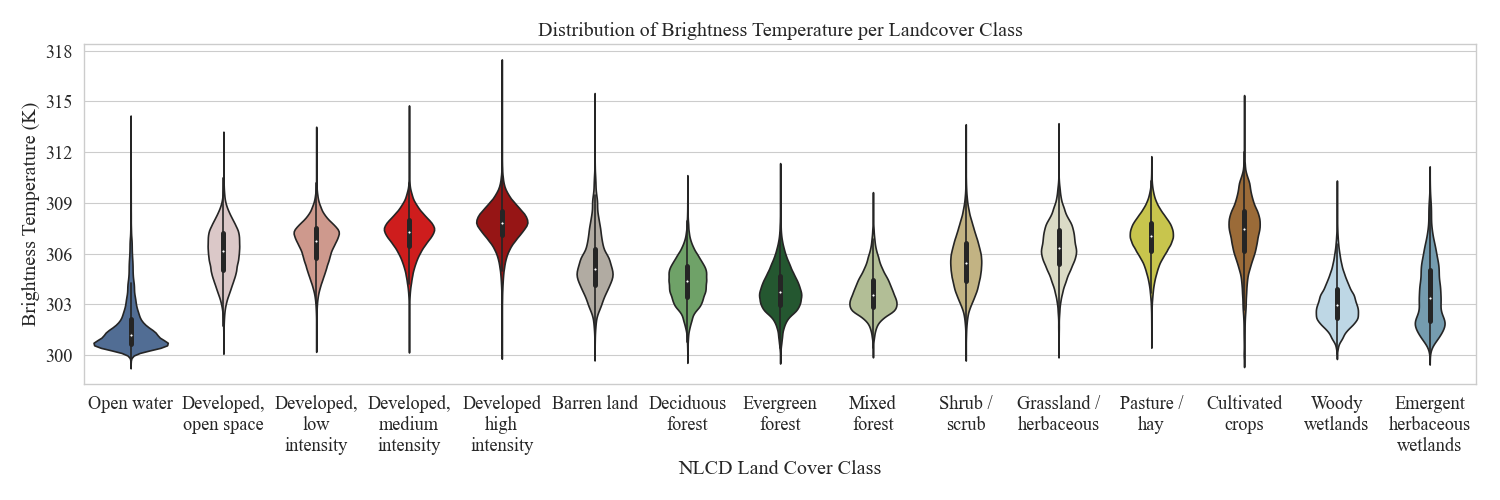

In [46]:
%matplotlib widget
from interpolator import Interpolator 

sns.set(style='whitegrid', context='paper', font='Times New Roman', font_scale=1.5)
city = 'San Antonio'
date_ = '20190816'
interp = Interpolator(root=p.join(root_, city), target_date=date_)
interp.plot_violins()
# plt.savefig('/Users/yuhaoliu/Downloads/motivation_spatial.png', dpi=300)

## Motivation for Temporal